# Libraries

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Import & View Data

In [2]:
train = pd.read_csv("./train_data_withlabels.csv")

In [3]:
test = pd.read_csv("./test_data_nolabels.csv")

In [4]:
train.head()

,dataid,localminute,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,target
0,1,2018-01-02 01:00:00,0.416,0.0,0.0,0.0,0.0,0,0.0,0
1,2,2018-01-02 01:01:00,0.416,0.0,0.0,0.0,0.0,0,0.0,0
2,3,2018-01-02 01:02:00,0.416,0.0,0.0,0.0,0.0,0,0.0,0
3,4,2018-01-02 01:03:00,0.415,0.0,0.0,0.0,0.0,0,0.0,0
4,5,2018-01-02 01:04:00,0.416,0.0,0.0,0.0,0.0,0,0.0,0


In [5]:
train.describe()

,dataid,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,target
count,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000
mean,209904.500000,1.138576,1.149224,0.000179,1.138460,0.904516,9.999983,3.171293,0.054411
std,121188.275241,1.551522,1.612034,1.979740,1.026167,0.741364,5.407102,2.393255,0.226826
min,1.000000,-4.780000,0.000000,-13.602000,-2.867713,0.000000,0.000000,0.000000,0.000000
25%,104952.750000,0.277000,0.096000,-0.245000,0.398881,0.185816,7.000000,1.016000,0.000000
50%,209904.500000,0.414000,0.231000,-0.001000,0.798396,0.900660,9.000000,2.895000,0.000000
75%,314856.250000,1.177000,2.279000,0.219000,1.566542,1.314512,12.000000,4.210000,0.000000
max,419808.000000,15.404000,14.912000,14.912000,7.931208,5.897778,92.000000,15.404000,1.000000


Here we see the data type of the `target` as binary, thus we will use a classifier

In [6]:
train.target.unique()

array([0, 1])

# Preprocessing

## Reduce Data

* reduce the number of attributes for training
    * remove `dataid` as it is not relevant to `target` result

In [7]:
train = train.iloc[:, 1:]

## Check and Handle Missing Values

From the count we can see that there are no missing values as the row count is still the same as our count in `describe` above

In [8]:
train_nulls = pd.notnull(train)
train = train[train_nulls]

In [9]:
train.describe()

,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,target
count,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000
mean,1.138576,1.149224,0.000179,1.138460,0.904516,9.999983,3.171293,0.054411
std,1.551522,1.612034,1.979740,1.026167,0.741364,5.407102,2.393255,0.226826
min,-4.780000,0.000000,-13.602000,-2.867713,0.000000,0.000000,0.000000,0.000000
25%,0.277000,0.096000,-0.245000,0.398881,0.185816,7.000000,1.016000,0.000000
50%,0.414000,0.231000,-0.001000,0.798396,0.900660,9.000000,2.895000,0.000000
75%,1.177000,2.279000,0.219000,1.566542,1.314512,12.000000,4.210000,0.000000
max,15.404000,14.912000,14.912000,7.931208,5.897778,92.000000,15.404000,1.000000


## Create new Features from Existing One

* separate `localminute` to 
    * month
    * date
    * weekday
    * hour
    * minute
 
 year and second will not be included as it would not be relevant to this analysis with all the data are of one value

In [10]:
# change type from string to datetime object
train.localminute = pd.to_datetime(train.localminute)

# create new columns
train['month'] = train.localminute.dt.month
train['date'] = train.localminute.dt.day
train['weekday'] = train.localminute.dt.weekday
train['hour'] = train.localminute.dt.hour
train['minute'] = train.localminute.dt.minute

# remove localminute column
train = train.iloc[:, 1:]

In [11]:
# move target column just for ease
target = train.pop('target')
train['target'] = target

In [12]:
train.describe()

,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,month,date,weekday,hour,minute,target
count,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000,419808.000000
mean,1.138576,1.149224,0.000179,1.138460,0.904516,9.999983,3.171293,5.367168,15.371884,2.997370,11.491596,29.499314,0.054411
std,1.551522,1.612034,1.979740,1.026167,0.741364,5.407102,2.393255,2.777114,8.681037,1.991407,6.920450,17.317885,0.226826
min,-4.780000,0.000000,-13.602000,-2.867713,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.277000,0.096000,-0.245000,0.398881,0.185816,7.000000,1.016000,3.000000,8.000000,1.000000,5.000000,14.000000,0.000000
50%,0.414000,0.231000,-0.001000,0.798396,0.900660,9.000000,2.895000,5.000000,15.000000,3.000000,11.000000,29.000000,0.000000
75%,1.177000,2.279000,0.219000,1.566542,1.314512,12.000000,4.210000,8.000000,23.000000,5.000000,17.000000,44.000000,0.000000
max,15.404000,14.912000,14.912000,7.931208,5.897778,92.000000,15.404000,10.000000,31.000000,6.000000,23.000000,59.000000,1.000000


## Remove Outliers

We want to have a quality training data thus we need to remove any "bad" or outliers. We remove outliers based on the number of outliers present in each category (except the timestamps), from low to high

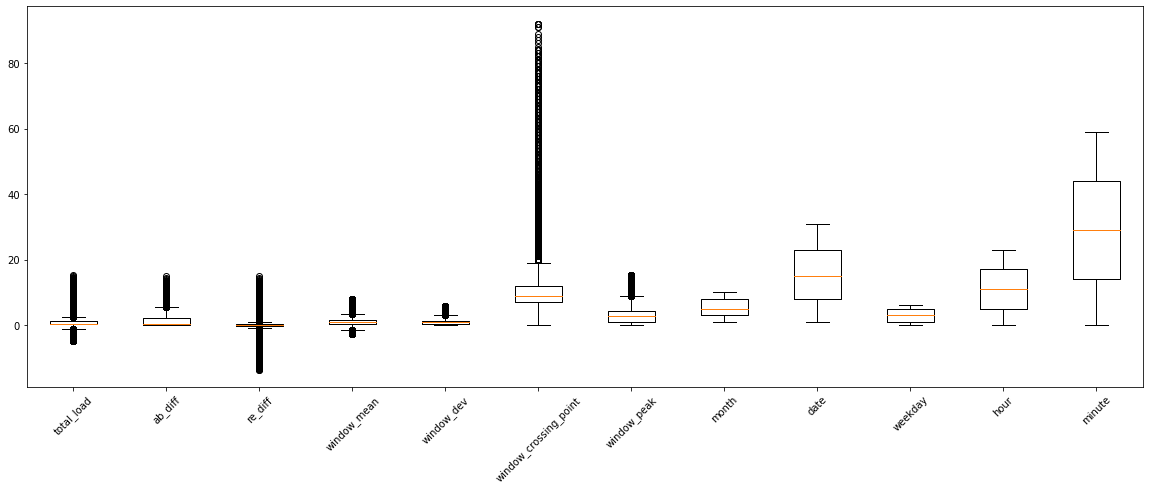

In [13]:
fig = plt.figure(figsize =(20, 7))
ax = fig.add_subplot(111)

ax.boxplot(train.iloc[:, :-1])
plt.xticks(list(range(1, 13)), train.iloc[:, :-1].columns, rotation = 45)

plt.show()

In [14]:
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1

pd.DataFrame(((train < (Q1 - 1.5 * IQR)) | (train > (Q3 + 1.5 * IQR))).sum()).sort_values(0)

,0
month,0
date,0
weekday,0
hour,0
minute,0
window_dev,5006
ab_diff,8933
window_peak,9735
window_crossing_point,16406
window_mean,21103


In [15]:
# window_dev outliers
vals = train.window_dev.describe() # var change here
q1 = vals['25%']
q3 = vals['75%']
iqr = q3-q1

bottom = q1 - (1.5 * iqr)
top = q3 + (1.5 * iqr)

train = train[train.window_dev > bottom] # var change here
train = train[train.window_dev < top] # var change here

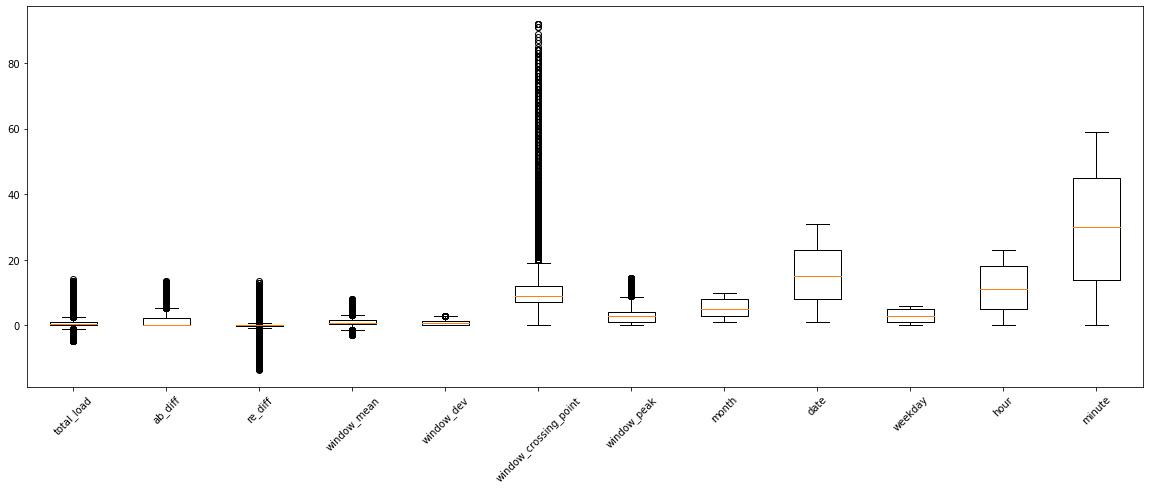

In [16]:
fig = plt.figure(figsize =(20, 7))
ax = fig.add_subplot(111)

ax.boxplot(train.iloc[:, :-1])
plt.xticks(list(range(1, 13)), train.iloc[:, :-1].columns, rotation = 45)

plt.show()

In [17]:
train.describe()

,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,month,date,weekday,hour,minute,target
count,414802.000000,414802.000000,414802.000000,414802.000000,414802.000000,414802.000000,414802.000000,414802.000000,414802.000000,414802.000000,414802.000000,414802.000000,414802.000000
mean,1.123149,1.113091,-0.002955,1.124759,0.871954,9.991372,3.097824,5.364162,15.291843,3.001618,11.481037,29.501577,0.052611
std,1.487608,1.545395,1.904524,1.002774,0.681218,5.388680,2.284899,2.780400,8.653440,1.988433,6.932284,17.320841,0.223255
min,-4.780000,0.000000,-13.477000,-2.867713,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.277000,0.095000,-0.240000,0.398079,0.182126,7.000000,1.003000,3.000000,8.000000,1.000000,5.000000,14.000000,0.000000
50%,0.413000,0.225000,-0.001000,0.792891,0.887496,9.000000,2.885000,5.000000,15.000000,3.000000,11.000000,30.000000,0.000000
75%,1.138000,2.238000,0.212000,1.550629,1.294849,12.000000,4.133000,8.000000,23.000000,5.000000,18.000000,45.000000,0.000000
max,14.232000,13.626000,13.626000,7.931208,3.007471,92.000000,14.384000,10.000000,31.000000,6.000000,23.000000,59.000000,1.000000


In [18]:
pd.DataFrame(((train < (Q1 - 1.5 * IQR)) | (train > (Q3 + 1.5 * IQR))).sum()).sort_values(0)

,0
window_dev,0
month,0
date,0
weekday,0
hour,0
minute,0
window_peak,7212
ab_diff,7604
window_crossing_point,15895
window_mean,19373


## Normalize Data

In [19]:
# get column names
col_names = train.columns.to_list()

# use sklearn to normalize data
train_normal = pd.DataFrame(StandardScaler().fit_transform(train))

# rename columns
train_normal.columns = col_names

In [20]:
train_normal.head()

,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,month,date,weekday,hour,minute,target
0,-0.475360,-0.720264,0.001552,-1.121649,-1.279994,-1.854143,-1.355783,-1.569618,-1.53602,-1.006632,-1.511919,-1.703244,-0.235653
1,-0.475360,-0.720264,0.001552,-1.121649,-1.279994,-1.854143,-1.355783,-1.569618,-1.53602,-1.006632,-1.511919,-1.645510,-0.235653
2,-0.475360,-0.720264,0.001552,-1.121649,-1.279994,-1.854143,-1.355783,-1.569618,-1.53602,-1.006632,-1.511919,-1.587776,-0.235653
3,-0.476033,-0.720264,0.001552,-1.121649,-1.279994,-1.854143,-1.355783,-1.569618,-1.53602,-1.006632,-1.511919,-1.530042,-0.235653
4,-0.475360,-0.720264,0.001552,-1.121649,-1.279994,-1.854143,-1.355783,-1.569618,-1.53602,-1.006632,-1.511919,-1.472308,-0.235653


In [21]:
train_normal.describe()

,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,month,date,weekday,hour,minute,target
count,4.148020e+05,4.148020e+05,4.148020e+05,4.148020e+05,4.148020e+05,4.148020e+05,4.148020e+05,4.148020e+05,4.148020e+05,4.148020e+05,4.148020e+05,4.148020e+05,4.148020e+05
mean,-1.103243e-14,1.318280e-14,3.353377e-16,-4.790647e-15,8.873921e-16,-1.005070e-14,-5.188633e-15,-1.335324e-12,3.292017e-14,6.095470e-16,-2.109924e-15,-2.421126e-16,4.954438e-14
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.968221e+00,-7.202638e-01,-7.074765e+00,-3.981432e+00,-1.279994e+00,-1.854143e+00,-1.355783e+00,-1.569618e+00,-1.651581e+00,-1.509541e+00,-1.656172e+00,-1.703244e+00,-2.356528e-01
25%,-5.687991e-01,-6.587908e-01,-1.244642e-01,-7.246702e-01,-1.012641e+00,-5.551221e-01,-9.168137e-01,-8.502966e-01,-8.426535e-01,-1.006632e+00,-9.349076e-01,-8.949678e-01,-2.356528e-01
50%,-4.773770e-01,-5.746699e-01,1.026599e-03,-3.309500e-01,2.281459e-02,-1.839732e-01,-9.314403e-02,-1.309747e-01,-3.372569e-02,-8.135255e-04,-6.939089e-02,2.877597e-02,-2.356528e-01
75%,9.983263e-03,7.279110e-01,1.128657e-01,4.246924e-01,6.207923e-01,3.727500e-01,4.530514e-01,9.480080e-01,8.907633e-01,1.005005e+00,9.403786e-01,8.947858e-01,-2.356528e-01
max,8.812046e+00,8.096908e+00,7.156103e+00,6.787629e+00,3.134854e+00,1.521870e+01,4.939469e+00,1.667330e+00,1.815252e+00,1.507914e+00,1.661643e+00,1.703062e+00,4.243532e+00


# Inference Task

## Correlation

In [22]:
c = train_normal.corr()
c

,total_load,ab_diff,re_diff,window_mean,window_dev,window_crossing_point,window_peak,month,date,weekday,hour,minute,target
total_load,1.000000,0.246765,-0.004244,0.729139,0.510522,0.081539,0.547408,0.197351,-0.007695,-0.010340,0.209222,-0.005382,0.579747
ab_diff,0.246765,1.000000,0.017262,0.475779,0.605268,-0.000387,0.583583,0.178820,-0.002089,-0.008989,0.183717,0.001350,0.179327
re_diff,-0.004244,0.017262,1.000000,-0.008761,0.034203,-0.014324,0.027668,-0.002010,0.001102,0.002250,-0.045911,-0.002001,0.030479
window_mean,0.729139,0.475779,-0.008761,1.000000,0.744253,0.104128,0.796660,0.293272,-0.010088,-0.014830,0.308033,0.000807,0.526765
window_dev,0.510522,0.605268,0.034203,0.744253,1.000000,0.065558,0.895985,0.399511,0.001864,-0.013629,0.234924,0.000956,0.333446
window_crossing_point,0.081539,-0.000387,-0.014324,0.104128,0.065558,1.000000,0.136749,0.005508,-0.004045,-0.017752,-0.083874,-0.000337,-0.104825
window_peak,0.547408,0.583583,0.027668,0.796660,0.895985,0.136749,1.000000,0.328091,0.008233,-0.023343,0.238160,0.000686,0.350002
month,0.197351,0.178820,-0.002010,0.293272,0.399511,0.005508,0.328091,1.000000,-0.065823,0.002971,-0.006164,-0.000373,0.000835
date,-0.007695,-0.002089,0.001102,-0.010088,0.001864,-0.004045,0.008233,-0.065823,1.000000,-0.001683,-0.000957,0.000070,-0.011323
weekday,-0.010340,-0.008989,0.002250,-0.014830,-0.013629,-0.017752,-0.023343,0.002971,-0.001683,1.000000,-0.005156,-0.000163,-0.002847


<AxesSubplot:>

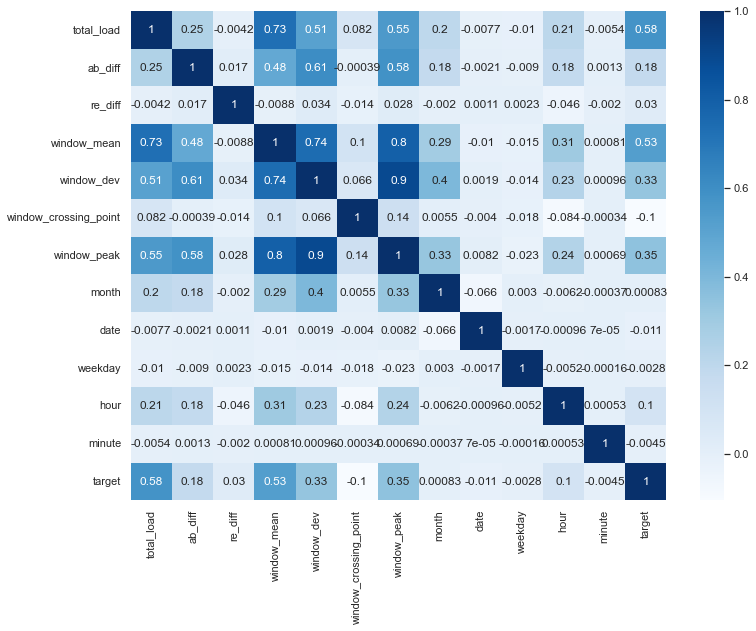

In [23]:
sns.set(rc={'figure.figsize':(12,9)})

sns.heatmap(c, cmap="Blues", annot=True)

In [24]:
top = c.iloc[:, -1:].reindex(c.target.abs().sort_values(ascending = False).index).iloc[1:, :]
top_features = top.index.to_list()
top

,target
total_load,0.579747
window_mean,0.526765
window_peak,0.350002
window_dev,0.333446
ab_diff,0.179327
window_crossing_point,-0.104825
hour,0.101363
re_diff,0.030479
date,-0.011323
minute,-0.004516


## Regression Analysis

### Test 1

* no normalisation
* no dummy variables

In [25]:
# split to train and validation
validation_x, train_x = train_test_split(train, test_size = 0.9, train_size = 0.1)

# separate x and y
train_y = train_x.target
train_x = train_x.iloc[:, :-1]

validation_y = validation_x.target
validation_x = validation_x.iloc[:, :-1]

In [26]:
#fit linear regression model
model = sm.OLS(train_y, train_x).fit()

#view model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.446
Model:                            OLS   Adj. R-squared (uncentered):              0.446
Method:                 Least Squares   F-statistic:                          2.509e+04
Date:                Mon, 06 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:40:36   Log-Likelihood:                      1.3029e+05
No. Observations:              373322   AIC:                                 -2.606e+05
Df Residuals:                  373310   BIC:                                 -2.604e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

### Test 2

* normalisation
* no dummy variables

In [73]:
# split to train and validation
validation_x, train_x = train_test_split(train_normal, test_size = 0.9, train_size = 0.1)

# separate x and y
train_y = train_x.target
train_x = train_x.iloc[:, :-1]

validation_y = validation_x.target
validation_x = validation_x.iloc[:, :-1]

In [74]:
#fit linear regression model
model = sm.OLS(train_y, train_x).fit()

#view model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.408
Model:                            OLS   Adj. R-squared (uncentered):              0.408
Method:                 Least Squares   F-statistic:                          2.167e+04
Date:                Fri, 03 Jun 2022   Prob (F-statistic):                        0.00
Time:                        00:30:47   Log-Likelihood:                      1.1332e+05
No. Observations:              377828   AIC:                                 -2.266e+05
Df Residuals:                  377816   BIC:                                 -2.265e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

### Test 3

* no normalisation
* dummy variables
* change dates to categorical
* not include month - because month doesnt match with test data anyway and p-value lowest

In [272]:
train3 = train.drop('month', axis = 1)

# convert dates to categorical
train3['date'] = train3['date'].astype('category')
train3['weekday'] = train3['weekday'].astype('category')
train3['hour'] = train3['hour'].astype('category')
train3['minute'] = train3['minute'].astype('category')

targ = train3.target
train3 = train3.drop('target', axis = 1)
train3['target'] = targ

train3 = pd.get_dummies(train3)

In [273]:
# split to train and validation
validation_x, train_x = train_test_split(train3, test_size = 0.9, train_size = 0.1)

# separate x and y
train_y = train_x.target
train_x = train_x.drop('target', axis = 1)

validation_y = validation_x.target
validation_x = validation_x.drop('target', axis = 1)

#fit linear regression model
model = sm.OLS(train_y, train_x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     2105.
Date:                Mon, 06 Jun 2022   Prob (F-statistic):               0.00
Time:                        14:58:53   Log-Likelihood:             1.2434e+05
No. Observations:              377828   AIC:                        -2.484e+05
Df Residuals:                  377702   BIC:                        -2.471e+05
Df Model:                         125                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
total_load                0.05

In [274]:
lr_model = LogisticRegression(max_iter=1000).fit(train_x, train_y)
val_y = lr_model.predict(validation_x)
pred_y = lr_model.predict(train_x)

print(classification_report(train_y, pred_y))
print(classification_report(validation_y, val_y))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    357274
           1       0.84      0.75      0.79     20554

    accuracy                           0.98    377828
   macro avg       0.91      0.87      0.89    377828
weighted avg       0.98      0.98      0.98    377828

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     39692
           1       0.83      0.74      0.78      2288

    accuracy                           0.98     41980
   macro avg       0.91      0.87      0.89     41980
weighted avg       0.98      0.98      0.98     41980



### Test 4

* no normalisation
* top 4 from pearson correlation - more than 0.25

In [158]:
features = ['total_load', 'window_mean', 'window_peak', 'window_dev', 'target']

train4 = train.filter(features)

In [159]:
# split to train and validation
validation_x, train_x = train_test_split(train4, test_size = 0.9, train_size = 0.1)

# separate x and y
train_y = train_x.target
train_x = train_x.drop('target', axis = 1)

validation_y = validation_x.target
validation_x = validation_x.drop('target', axis = 1)

#fit linear regression model
model = sm.OLS(train_y, train_x).fit()

#view model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.379
Model:                            OLS   Adj. R-squared (uncentered):              0.379
Method:                 Least Squares   F-statistic:                          5.762e+04
Date:                Fri, 03 Jun 2022   Prob (F-statistic):                        0.00
Time:                        01:23:10   Log-Likelihood:                      1.0395e+05
No. Observations:              377828   AIC:                                 -2.079e+05
Df Residuals:                  377824   BIC:                                 -2.078e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

### Test 5

* no normalisation
* dummy variables
* change dates to categorical
* not include last 2 insignificant var

In [246]:
features = top_features[:-2]

train5 = train[[*features, "target"]] #train.drop('month', axis = 1)

# convert dates to categorical
train5['date'] = train5['date'].astype('category')
#train5['weekday'] = train5['weekday'].astype('category')
#train5['hour'] = train5['hour'].astype('category')
#train5['minute'] = train5['minute'].astype('category')

train5 = pd.get_dummies(train5)

/var/folders/h3/q7m1_6bd3sj67ss_pjmmx7jw0000gn/T/ipykernel_87196/2125194951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train5['date'] = train5['date'].astype('category')


In [227]:
# split to train and validation
validation_x, train_x = train_test_split(train5, test_size = 0.9, train_size = 0.1)

# separate x and y
train_y = train_x.target
train_x = train_x.drop('target', axis = 1)

validation_y = validation_x.target
validation_x = validation_x.drop('target', axis = 1)

#fit linear regression model
model = sm.OLS(train_y, train_x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     2203.
Date:                Sun, 05 Jun 2022   Prob (F-statistic):               0.00
Time:                        11:20:01   Log-Likelihood:             1.2418e+05
No. Observations:              377828   AIC:                        -2.481e+05
Df Residuals:                  377708   BIC:                        -2.468e+05
Df Model:                         119                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
total_load                0.05

In [228]:
lr_model = LogisticRegression(max_iter=1000).fit(train_x, train_y)
val_y = lr_model.predict(validation_x)
pred_y = lr_model.predict(train_x)

print(classification_report(train_y, pred_y))
print(classification_report(validation_y, val_y))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    357292
           1       0.84      0.75      0.79     20536

    accuracy                           0.98    377828
   macro avg       0.91      0.87      0.89    377828
weighted avg       0.98      0.98      0.98    377828

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     39674
           1       0.83      0.72      0.78      2306

    accuracy                           0.98     41980
   macro avg       0.91      0.86      0.88     41980
weighted avg       0.98      0.98      0.98     41980



### Final Model - Test 3 with StandardScaler

* no normalisation
* dummy variables
* change dates to categorical
* not include month - because month doesnt match with test data anyway and p-value lowest
* StandardScaler with Pipeline

In [36]:
train_f = train.drop('month', axis = 1)

# convert dates to categorical
train_f['date'] = train_f['date'].astype('category')
train_f['weekday'] = train_f['weekday'].astype('category')
train_f['hour'] = train_f['hour'].astype('category')
train_f['minute'] = train_f['minute'].astype('category')

targ = train_f.target
train_f = train_f.drop('target', axis = 1)
train_f['target'] = targ

train_f = pd.get_dummies(train_f)

# split to train and validation
validation_x, train_x = train_test_split(train_f, test_size = 0.9, train_size = 0.1)

# separate x and y
train_y = train_x.target
train_x = train_x.drop('target', axis = 1)

validation_y = validation_x.target
validation_x = validation_x.drop('target', axis = 1)

#fit linear regression model
model = sm.OLS(train_y, train_x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     2080.
Date:                Tue, 07 Jun 2022   Prob (F-statistic):               0.00
Time:                        14:28:21   Log-Likelihood:             1.2920e+05
No. Observations:              373322   AIC:                        -2.581e+05
Df Residuals:                  373196   BIC:                        -2.568e+05
Df Model:                         125                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
total_load                0.06

#### Logistic Regression

In [26]:
lr_pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 1000)).fit(train_x, train_y)
#lr_model = LogisticRegression(max_iter=1000).fit(train_x, train_y)

val_y = lr_pipe.predict(validation_x)
pred_y = lr_pipe.predict(train_x)

print(classification_report(train_y, pred_y))
print(classification_report(validation_y, val_y))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    353640
           1       0.85      0.77      0.81     19682

    accuracy                           0.98    373322
   macro avg       0.92      0.88      0.90    373322
weighted avg       0.98      0.98      0.98    373322

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     39339
           1       0.84      0.74      0.79      2141

    accuracy                           0.98     41480
   macro avg       0.91      0.87      0.89     41480
weighted avg       0.98      0.98      0.98     41480



#### KNN Neighbours

* map the best n

In [27]:
n_max = 10

df = pd.DataFrame({"N" : list(range(1, n_max+1)), "acc_t" : 0*n_max, "acc_v" : 0*n_max})

for n in range(1 , n_max+1):
    
    # train model
    k_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = n, algorithm = "kd_tree")).fit(train_x, train_y)
    #k_model = KNeighborsClassifier(n_neighbors = n, algorithm = "kd_tree").fit(train_x, train_y)
    pred_y = k_pipe.predict(train_x) # change var here
    val_y = k_pipe.predict(validation_x) # change var here
    
    # get accuracy for train prediction
    tn, fp, fn, tp = confusion_matrix(train_y, pred_y).ravel()
    acc_t = (tn + tp) / (tn + fp + tp +fn)
    df.iloc[n-1, 1] = acc_t
    
    # get accuracy for validation prediction
    tn, fp, fn, tp = confusion_matrix(validation_y, val_y).ravel()
    acc_v = (tn + tp) / (tn + fp + tp + fn)
    df.iloc[n-1, 2] = acc_v
    
    print(n, " done!")
    
print("Done!")

1  done!
2  done!
3  done!
4  done!
5  done!
6  done!
7  done!
8  done!
9  done!
10  done!
Done!


In [25]:
k_model = KNeighborsClassifier(n_neighbors = 3, algorithm = "kd_tree").fit(train_x, train_y)

In [26]:
pred_y = k_model.predict(train_x)
print(classification_report(train_y, pred_y))

In [28]:
val_y = k_model.predict(validation_x)
print(classification_report(validation_y, val_y))

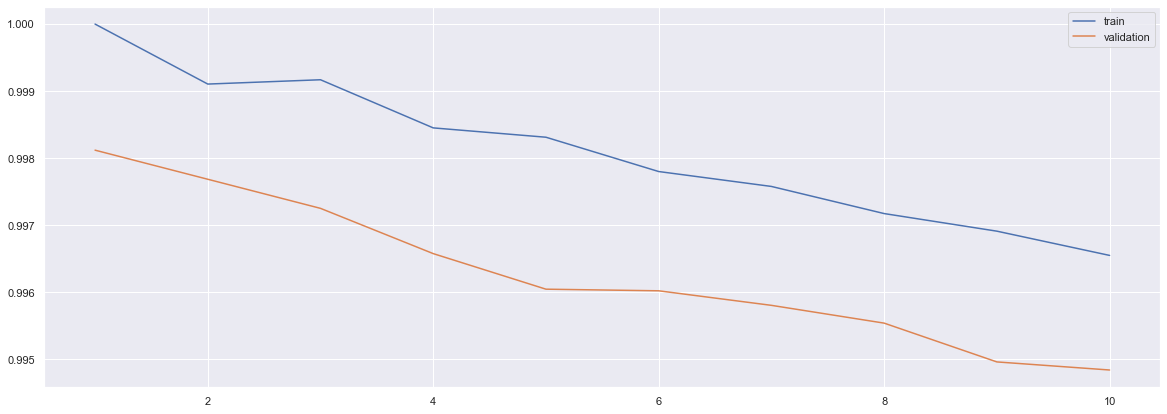

In [28]:
fig = plt.figure(figsize =(20, 7))
ax = fig.add_subplot(111)

ax.plot(df.N, df.acc_t, label = "train")
ax.plot(df.N, df.acc_v, label = "validation")
ax.legend()

#### Random Forest

In [38]:
rf_model = RandomForestClassifier(max_depth=20, random_state=0).fit(train_x, train_y)

pred_y = rf_model.predict(train_x) # change var here
val_y = rf_model.predict(validation_x) # change var here

print(classification_report(train_y, pred_y))
print(classification_report(validation_y, val_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    353733
           1       0.99      0.97      0.98     19589

    accuracy                           1.00    373322
   macro avg       0.99      0.99      0.99    373322
weighted avg       1.00      1.00      1.00    373322

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39246
           1       0.98      0.95      0.96      2234

    accuracy                           1.00     41480
   macro avg       0.99      0.98      0.98     41480
weighted avg       1.00      1.00      1.00     41480



In [39]:
rf_model = RandomForestClassifier(max_depth=50, random_state=0).fit(train_x, train_y)

pred_y = rf_model.predict(train_x) # change var here
val_y = rf_model.predict(validation_x) # change var here

print(classification_report(train_y, pred_y))
print(classification_report(validation_y, val_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    353733
           1       1.00      1.00      1.00     19589

    accuracy                           1.00    373322
   macro avg       1.00      1.00      1.00    373322
weighted avg       1.00      1.00      1.00    373322

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39246
           1       0.99      0.96      0.98      2234

    accuracy                           1.00     41480
   macro avg       1.00      0.98      0.99     41480
weighted avg       1.00      1.00      1.00     41480



# Creating Model

We will be creating

* Logistic Regression
* KNN Neighbours
* Random Forest

In [27]:
train_y = train.target
train_x = train.iloc[:, :-1]

train_x = train_x.drop('month', axis = 1)

# convert dates to categorical
train_x['date'] = train_x['date'].astype('category')
train_x['weekday'] = train_x['weekday'].astype('category')
train_x['hour'] = train_x['hour'].astype('category')
train_x['minute'] = train_x['minute'].astype('category')

targ = train_x.target
train_x = train_x.drop('target', axis = 1)

train_x = pd.get_dummies(train_x)

In [28]:
test = pd.read_csv("./test_data_nolabels.csv")

# transform test data

# get dataid
test_id = test.dataid

# change type from string to datetime object
test.localminute = pd.to_datetime(test.localminute)

# create new columns
#test['month'] = test.localminute.dt.month
test['date'] = test.localminute.dt.day
test['weekday'] = test.localminute.dt.weekday
test['hour'] = test.localminute.dt.hour
test['minute'] = test.localminute.dt.minute

# normalise test data
#test = pd.DataFrame(MinMaxScaler().fit_transform(test))

# remove localminute and dataid column
test = test.iloc[:, 2:]

# select test columns
#test = test[features]

# convert dates to categorical
#test['month'] = test['month'].astype('category')
test['date'] = test['date'].astype('category')
test['weekday'] = test['weekday'].astype('category')
test['hour'] = test['hour'].astype('category')
test['minute'] = test['minute'].astype('category')


test = pd.get_dummies(test)


#features = ['total_load', 'window_mean', 'window_peak', 'window_dev']
#test = test.filter(features)

In [29]:
# make sure no differences in data
set(train_x.columns) - set(test.columns)

set()

## Logistic Regression

### Pipeline

In [30]:
lr_pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 1000))
lr_pipe = lr_pipe.fit(train_x, train_y)

pred_y = lr_pipe.predict(train_x)
print(classification_report(train_y, pred_y))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    392979
           1       0.85      0.76      0.80     21823

    accuracy                           0.98    414802
   macro avg       0.92      0.88      0.90    414802
weighted avg       0.98      0.98      0.98    414802



In [31]:
lr_test = lr_pipe.predict(test)

lr_final = pd.DataFrame({"dataid" : test_id, "target" : lr_test})
lr_final.to_csv("lr_result.csv", index = False)
lr_final.target.value_counts()

0    101332
1      3620
Name: target, dtype: int64

### Model Only

In [231]:
lr_model = LogisticRegression(max_iter=1000).fit(train_x, train_y)

pred_y = lr_model.predict(train_x)
print(classification_report(train_y, pred_y))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    357292
           1       0.84      0.75      0.79     20536

    accuracy                           0.98    377828
   macro avg       0.91      0.87      0.89    377828
weighted avg       0.98      0.98      0.98    377828

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     39674
           1       0.83      0.72      0.78      2306

    accuracy                           0.98     41980
   macro avg       0.91      0.86      0.88     41980
weighted avg       0.98      0.98      0.98     41980



In [165]:
lr_test = lr_model.predict(test)

lr_final = pd.DataFrame({"dataid" : test_id, "target" : lr_test})
lr_final.to_csv("lr_result.csv", index = False)
lr_final.target.value_counts()

## KNN Neighbours



# References

* https://www.altexsoft.com/blog/datascience/preparing-your-dataset-for-machine-learning-8-basic-techniques-that-make-your-data-better/

* https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression

In [66]:
? classification_report